In [45]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

trainer = Trainer(config.load("config_spacy.yml"))
training_data = load_data('test_data.json')
interpreter = trainer.train(training_data)

/home/starliu/anaconda3/lib/python3.7/site-packages/rasa_nlu/extractors/entity_synonyms.py:105: UserWarning: Found conflicting synonym definitions for 'apple'. Overwriting target 'AAPL' with 'APPL'. Check your training data and remove conflicting synonym definitions to prevent this from happening.
  repr(replacement)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/starliu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [2]:
# iexfinance
from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data
from iexfinance.stocks import get_historical_intraday

from datetime import datetime
import time

import matplotlib.pyplot as plt

import random

In [3]:
CONFUSE = -1
INIT = 0
MAIN = 1
CURRENT = 2
HISTORY = 3
CLOSE = 4
INTRADAY = 5

In [4]:
responses = {
    "greet":["Hi! I am a chatbot. What can I do for you?",
             "Nice to meet you. I'm a chatbot and I'm ready to help you.",
            ],
    "thank":["You're welcome. I hope to help you as much as I can!",
             "I'm glad that I do help you!",
            ],
    "introduce":["I can help you with: \n1. Get current price\n2. Get history price in a range\n3. Get close price\n4. Get intraday data"],
    
    "current_price":["The current price of {} is {}\n",
                     "{} has a real-time price of {}\n",
                    ], 
                 
    "vague":["Please specify a range.",
             "Which time do you want to know?"
            ],
}

def resp_sentence(intent):
    return random.choice(responses[intent])

In [5]:
policy_rules = {
    (INIT, "greet"): (MAIN, resp_sentence("greet"), None),
    (MAIN, "greet"): (MAIN, resp_sentence("greet"), None),
    (MAIN, "thank"): (MAIN, resp_sentence("thank"), None),
    
    (MAIN,"introduce"): (MAIN, resp_sentence("introduce"), None),
    
    (MAIN, "current_price"): (CURRENT, resp_sentence("current_price"), None),
    (CURRENT, "current_price"): (CURRENT, resp_sentence("current_price"), None),
    (CURRENT, "thank"): (MAIN, resp_sentence("thank"), None),
   
    (MAIN, "daily_historical_price"): (MAIN, "Here is a figure:", None),
    (MAIN, "daily_historical_price_vague"): (MAIN, resp_sentence("vague"), HISTORY),
    (HISTORY, "daily_historical_price_vague"): (MAIN, resp_sentence("vague"), HISTORY),
    (MAIN, "date_time"): (HISTORY, "Here is a figure:", None),
    (HISTORY, "date_time"): (HISTORY, "Here is a figure:", None),
    (HISTORY, "thank"): (MAIN, resp_sentence("thank"), None),
    
    (MAIN, "close_price"): (MAIN, "Here is a figure:", None),
    (MAIN, "close_price"): (MAIN, resp_sentence("vague"), CLOSE),
    (CLOSE, "close_price"): (MAIN, resp_sentence("vague"), CLOSE),
    (MAIN, "date_time"): (CLOSE, "Here is a figure:", None),
    (CLOSE, "date_time"): (CLOSE, "Here is a figure:", None),
    (CLOSE, "thank"): (MAIN, resp_sentence("thank"), None),
    
    (MAIN, "intraday"): (MAIN, "Here is a figure:", None),
}

In [54]:
def send_message(state, pending, message):
    #print("old_state: ", state, "message: ", message, "pending: ", pending)
    new_state, response, pending_state = respond(state, message)
    
    #print("new_state: ", new_state, "response: ", response, "pending_state: ", pending_state)
    
    if pending is not None:
        new_state, response, pending_state = policy_rules[pending]
    if pending_state is not None:
        pending = (pending_state, get_intent(message))
        
    return new_state, pending, response, get_intent(message)

known_company='AAPL'

def respond(state, message):
    entity = get_entity(message)

    # print("res_state: ", state, "intent: ", get_intent(message))
    
    try:
        new_state = policy_rules[(state, get_intent(message))][0]
        # print(new_state)
    except KeyError:
        new_state = CONFUSE
        pending_state = policy_rules[(state, get_intent(message))][2]
    
    if get_intent(message) == 'greet':
        response = policy_rules[(state, get_intent(message))][1]
    if get_intent(message) == 'thank':
        response = policy_rules[(state, get_intent(message))][1]
    if get_intent(message) == 'introduce':
        response = policy_rules[(state, get_intent(message))][1]
        
    
    if get_intent(message) == 'current_price':
        response = policy_rules[(state, get_intent(message))][1].format(entity, get_current_price(message))
    if get_intent(message) == 'daily_historical_price':
        response = policy_rules[(state, get_intent(message))][1]
        get_history_price(message)
    if get_intent(message) == 'vague':
        response = policy_rules[(state, get_intent(message))][1]
        known_company=get_company(message)
    if get_intent(message) == 'date_time':
        response = policy_rules[(state, get_intent(message))][1]
        get_history_price(message)
    

    if get_intent(message) == 'close_price':
        response = policy_rules[(state, get_intent(message))][1]
        get_close_price(message)
    if get_intent(message) == 'vague':
        response = policy_rules[(state, get_intent(message))][1]
        known_company=get_company(message)
    if get_intent(message) == 'date_time':
        response = policy_rules[(state, get_intent(message))][1]
        get_close_price(message)
    
    if get_intent(message) == 'intraday':
        response = policy_rules[(state, get_intent(message))][1]
        get_intraday(message)
    
    return new_state, response, pending_state


def get_intent(message):
    return interpreter.parse(message)['intent']['name']

def get_entity(message):
    
    if interpreter.parse(message)['entities'] == []:
        return []
    
    if interpreter.parse(message)['entities'][0]['entity'] == 'company':
        return interpreter.parse(message)['entities'][0]['value']
  
    return [interpreter.parse(message)['entities'][0]['value'],
                interpreter.parse(message)['entities'][1]['value']]

In [61]:
def get_company(message):
    comprehended_data = interpreter.parse(message)
    return comprehended_data['entities'][0]['value']

def get_current_price(message):
    company = get_company(message)
    print("Company: ", company)
    
    prices = Stock(company,token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43').get_price()
    return prices

def draw_picture(data):
    plot = data.plot()
    fig = plot.get_figure()
    fig.savefig('result.png')
    
def get_history_price(message,known_company):
    comprehended_data = interpreter.parse(message)
    if len(comprehended_data['entities']) == 2:
        time_period = [comprehended_data['entities'][0]['value'],
                       comprehended_data['entities'][1]['value']]

        start_time_splited = time_period[0].split(' - ')
        end_time_splited = time_period[1].split(' - ')
        
        start_year = int(start_time_splited[0])
        start_month = int(start_time_splited[1])
        start_day = int(start_time_splited[2])
        
        end_year = int(end_time_splited[0])
        end_month = int(end_time_splited[1])
        end_day = int(end_time_splited[2])

        start_time = datetime(start_year, start_month, start_day)
        end_time = datetime(end_year, end_month, end_day)
        
        data = get_historical_data(known_company,start_time,end_time,output_format = 'pandas',token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]
    
    else:
        
        time_period = [comprehended_data['entities'][1]['value'],
                       comprehended_data['entities'][2]['value']]

        start_time_splited = time_period[0].split('-')
        end_time_splited = time_period[1].split('-')

        start_year = int(start_time_splited[0])
        start_month = int(start_time_splited[1])
        start_day = int(start_time_splited[2])
    
        end_year = int(end_time_splited[0])
        end_month = int(end_time_splited[1])
        end_day = int(end_time_splited[2])

        start_time = datetime(start_year, start_month, start_day)
        end_time = datetime(end_year, end_month, end_day)
        
        data = get_historical_data(known_company,start_time,end_time,output_format = 'pandas',token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]
        
    draw_picture(data)
    
    
def get_close_price(message,known_company):
    comprehended_data = interpreter.parse(message)
    if len(comprehended_data['entities']) == 2:
        time_period = [comprehended_data['entities'][0]['value'],
                       comprehended_data['entities'][1]['value']]

        start_time_splited = time_period[0].split(' - ')
        end_time_splited = time_period[1].split(' - ')
        
        start_year = int(start_time_splited[0])
        start_month = int(start_time_splited[1])
        start_day = int(start_time_splited[2])
        
        end_year = int(end_time_splited[0])
        end_month = int(end_time_splited[1])
        end_day = int(end_time_splited[2])

        start_time = datetime(start_year, start_month, start_day)
        end_time = datetime(end_year, end_month, end_day)
        
        data = get_historical_data(known_company,start_time,end_time,close_only = True,output_format = 'pandas',token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]
    
    else:
        
        time_period = [comprehended_data['entities'][1]['value'],
                       comprehended_data['entities'][2]['value']]

        start_time_splited = time_period[0].split('-')
        end_time_splited = time_period[1].split('-')

        start_year = int(start_time_splited[0])
        start_month = int(start_time_splited[1])
        start_day = int(start_time_splited[2])
    
        end_year = int(end_time_splited[0])
        end_month = int(end_time_splited[1])
        end_day = int(end_time_splited[2])

        start_time = datetime(start_year, start_month, start_day)
        end_time = datetime(end_year, end_month, end_day)
        
        data = get_historical_data(known_company,start_time,end_time,close_only = True,output_format = 'pandas',token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]
    
    draw_picture(data)

def get_intraday(message):
    comprehended_data = interpreter.parse(message)
    
    if len(comprehended_data['entities']) == 1:
        data=get_historical_intraday(comprehended_data['entities'][0]['value'],output_format = 'pandas',token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]

    else: 
        
        if len(comprehended_data['entities']) == 2:
            time_period = comprehended_data['entities'][1]['value']
            time_splited = time_period.split('-')
            
            year = time_splited[0]
            month = time_splited[1]
            day = time_splited[2]
            
            time = datetime(year,month,day)
            
            data = get_historical_intraday(comprehended_data['entities'][0]['value'],date=time,output_format = 'pandas',token = 'sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]

    draw_picture(data)

I wanna know the intraday data of AAPL
USER: I wanna know the intraday data of AAPL
[Intent: intraday]
old_state:  1 message:  I wanna know the intraday data of AAPL pending:  None
new_state:  1 response:  Here is a figure: pending_state:  None
BOT: Here is a figure:


KeyboardInterrupt: 

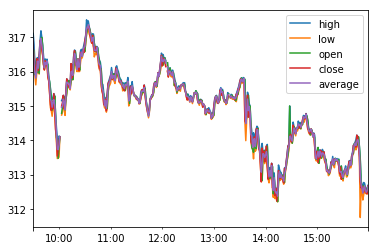

In [69]:
while True:
    state = MAIN
    pending = None

    msg = input()
    print("USER: " + msg)
    print("[Intent: " + get_intent(msg) + "]")

    state, pending, final_response, message_intent = send_message(state, pending, msg)

    print("BOT: " + final_response)

In [30]:
get_intent('i wanna know the intraday data of AAPL')

'intraday'

In [25]:
get_intent('i wanna know the current price of AAPL')

'current_price'

In [26]:
get_intent('what is the close price of AAPL')

'close_price_vague'

In [27]:
get_intent('tell me the close price of AAPL')

'close_price_vague'

In [28]:
get_intent('the current price of AAPL')

'current_price'

In [29]:
get_intent('from 2018-1-1 to 2019-3-7')

'date_time'

In [46]:
get_intent('i wanna know the history price of apple')

'daily_historical_price_vague'

In [59]:
data = get_historical_intraday('AAPL',output_format='pandas',token='sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]

In [58]:
get_historical_intraday('AAPL',output_format='pandas',token='sk_9a194d45d5ea4f8389b05aec83b8ee43')[['high','low','open','close','average']]

,high,low,open,close,average
2020-01-14 09:30:00,317.115,316.290,316.645,316.670,316.927
2020-01-14 09:31:00,316.780,316.000,316.630,316.260,316.234
2020-01-14 09:32:00,316.235,315.875,315.920,316.070,315.967
2020-01-14 09:33:00,316.080,315.615,316.080,315.945,315.812
2020-01-14 09:34:00,316.380,315.930,315.960,316.380,316.003
...,...,...,...,...,...
2020-01-14 15:55:00,312.745,312.600,312.630,312.640,312.670
2020-01-14 15:56:00,312.640,312.460,312.640,312.590,312.529
2020-01-14 15:57:00,312.530,312.440,312.530,312.470,312.486
2020-01-14 15:58:00,312.590,312.440,312.460,312.440,312.536


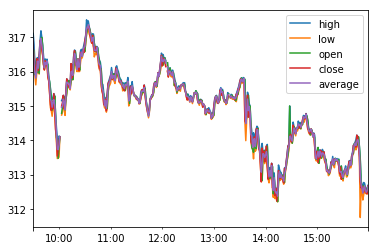

In [60]:
plot=data.plot()

In [50]:
fig=plot.get_figure()

In [52]:
fig.savefig('result.png')

In [66]:
from wxpy import *

bot = Bot()

my_friend = bot.friends().search('天岑Star')[0]


@bot.register(my_friend, TEXT)
def auto_reply(msg):
    state = MAIN
    pending = None
    print(get_intent(msg.text))
    
    state, pending, final_response, message_intent = send_message(state, pending, msg.text)
    msg.reply(final_response)
    
    if message_intent == 'clear_historical_data' or message_intent == 'add_historical_data':
        msg.reply_image('result.png')
    return fianl_response

bot.join()


Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.


KeyError: 'pass_ticket'